In [1]:
!pip install pmdarima

     |████████████████████████████████| 921kB 2.8MB/s 
     |████████████████████████████████| 24.8MB 71.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
scaler = MinMaxScaler()
df_crawl = pd.read_csv("crawl.csv",parse_dates=['date'], index_col='date')
df_active = pd.read_csv('active.csv',parse_dates=['date'], index_col='date')
df_sum_crawl = df_crawl['2016-08-01':'2019-07-31'].resample('M').sum()
df_sum_active = df_active['2016-08-01':'2019-07-31'].resample('M').sum()
data = pd.concat([df_sum_crawl['crawl unique'],df_sum_active['active unique']],axis=1)
data[['crawl unique', 'active unique']] = scaler.fit_transform(data[['crawl unique', 'active unique']])


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-54.692, BIC=-45.366, Fit time=0.473 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-45.793, BIC=-41.797, Fit time=0.070 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-44.850, BIC=-39.521, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-45.530, BIC=-40.202, Fit time=0.092 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-47.668, BIC=-39.674, Fit time=0.295 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-50.596, BIC=-39.939, Fit time=0.396 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-52.664, BIC=-44.671, Fit time=0.332 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-57.754, BIC=-47.096, Fit time=0.411 seconds
Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=-54.710, BIC=-41.388, Fit time=0.516 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1);

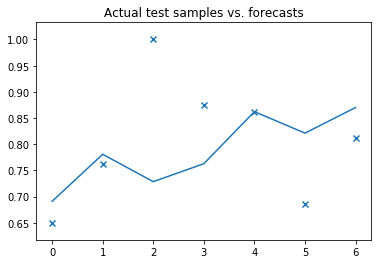

In [45]:
# #############################################################################
# Load the data and split it into separate pieces

train, test = data[:29], data[29:]

# Fit a simple auto_arima model
forecast_active_pages = pm.auto_arima(y=train['active unique'], exogenous=train["crawl unique"].values.reshape(-1, 1), trace=1,
                    seasonal=True,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=True)

print(forecast_active_pages.summary())

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test['active unique'].shape[0])
plt.scatter(x, test['active unique'], marker='x')
plt.plot(x, forecast_active_pages.predict(exogenous=test['crawl unique'].values.reshape(-1, 1),n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show();

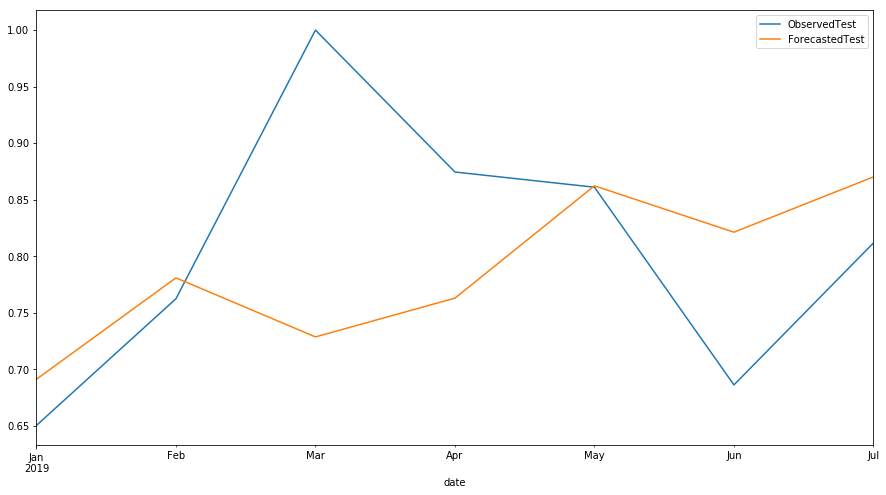

In [46]:
predicts = pd.DataFrame(forecast_active_pages.predict(exogenous=test['crawl unique'].values.reshape(-1, 1),n_periods=test.shape[0]), index = test.index)
pd.concat([test['active unique'],predicts],axis=1).plot(figsize=(15,8))
L=plt.legend()
L.get_texts()[0].set_text('ObservedTest')
L.get_texts()[1].set_text('ForecastedTest')